In [ ]:
import numpy as np 
import pandas as pd 
from tensorflow.keras.layers import Embedding
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
import seaborn as sns
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.probability import FreqDist
import string as s
import re
import matplotlib.pyplot as plt
from sklearn.model_selection import cross_val_score
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import train_test_split
import os
nltk.download('punkt')
from nltk.stem.porter import PorterStemmer
ps = PorterStemmer()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


In [ ]:
df = pd.read_csv('FakeNews_and_Clickbait_Detection.csv')
df.head(5)

,Unnamed: 0,id,title,author,text,label,clickbait
0,0,0,House Dem Aide: We Didn’t Even See Comey’s Let...,Darrell Lucus,House Dem Aide: We Didn’t Even See Comey’s Let...,1,1
1,1,1,"FLYNN: Hillary Clinton, Big Woman on Campus - ...",Daniel J. Flynn,Ever get the feeling your life circles the rou...,0,0
2,2,2,Why the Truth Might Get You Fired,Consortiumnews.com,"Why the Truth Might Get You Fired October 29, ...",1,1
3,3,3,15 Civilians Killed In Single US Airstrike Hav...,Jessica Purkiss,Videos 15 Civilians Killed In Single US Airstr...,1,0
4,4,4,Iranian woman jailed for fictional unpublished...,Howard Portnoy,Print \nAn Iranian woman has been sentenced to...,1,0


In [ ]:
df = df.dropna()

In [ ]:
x = df.drop(df.columns[[0,5,6]], axis = 1)
y = pd.DataFrame()
y['label'] = df['label'].values
y['clickbait'] = df['clickbait'].values

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=42)

In [ ]:
len(X_train)
X_train.head(5)

,id,title,author,text
6179,6354,Volatility Returns to Oil Market After OPEC De...,Jad Mouawad,It’s back to Square 1 for the oil markets. The...
14752,15151,No Debate That Hillary Clinton’s Polling Numbe...,Nate Cohn,"The polls are beginning to trickle in, and i..."
5595,5755,Lie to Me: Fiction in the Post-Truth Era - The...,Adam Kirsch,American novelists have long complained about ...
16460,16898,"Halloween, Instagram Style - The New York Times",Bonnie Wertheim,Last night Eleven from “Stranger Things” and t...
614,628,There’s Only One Trump Administration Position...,John Carney,While support for the Trump administration’s p...


In [ ]:
len(X_train)
X_train.head(5)

,id,title,author,text
6179,6354,Volatility Returns to Oil Market After OPEC De...,Jad Mouawad,It’s back to Square 1 for the oil markets. The...
14752,15151,No Debate That Hillary Clinton’s Polling Numbe...,Nate Cohn,"The polls are beginning to trickle in, and i..."
5595,5755,Lie to Me: Fiction in the Post-Truth Era - The...,Adam Kirsch,American novelists have long complained about ...
16460,16898,"Halloween, Instagram Style - The New York Times",Bonnie Wertheim,Last night Eleven from “Stranger Things” and t...
614,628,There’s Only One Trump Administration Position...,John Carney,While support for the Trump administration’s p...


# **Correlation between Clickbait and Label columns**

In [ ]:
contigency= pd.crosstab(df['label'], df['clickbait']) 
print(contigency)

clickbait     0     1
label                
0          7745  2616
1          5607  2317


In [ ]:
contigency_pct = pd.crosstab(df['label'], df['clickbait'], normalize='index')
contigency_pct

clickbait,0,1
label,,
0,0.747515,0.252485
1,0.707597,0.292403


In [ ]:
# Chi-square test of independence. 
from scipy.stats import chi2_contingency
chi_sq, p_value, dof, expected = chi2_contingency(contigency) 
# Print the p-value
print(format(p_value, '.16f'))

0.0000000018603149


In [ ]:
#cramer's v score of correlation calculation
n = contigency.sum().sum()
dof = min(contigency.shape)-1
# calculating cramer's v
v = np.sqrt(chi_sq/(n*dof))
# printing results
print(f'V = {v}')

V = 0.04444213788240863


# Fakenews detection

In [ ]:
y_train_fakenews = y_train['label']
y_test_fakenews = y_test['label']

In [ ]:
voc_size = 9500
message_train = X_train.copy()
message_test = X_test.copy()
message_train.reset_index(inplace = True)
message_test.reset_index(inplace = True)

In [ ]:
corpus_train = []
for i in range(0, len(message_train)):
   
    temp = re.sub('[^a-zA-Z]', ' ', message_train['text'][i])
    temp = temp.lower()
    temp = temp.split()
    
    temp = [ps.stem(word) for word in temp if not word in stopwords.words('english')]
    temp = ' '.join(temp)
    corpus_train.append(temp)

In [ ]:
corpus_test = []
for i in range(0, len(message_test)):
   
    temp = re.sub('[^a-zA-Z]', ' ', message_test['text'][i])
    temp = temp.lower()
    temp = temp.split()
    
    temp = [ps.stem(word) for word in temp if not word in stopwords.words('english')]
    temp = ' '.join(temp)
    corpus_test.append(temp)

In [ ]:
word_dict={}
for i in range(len(corpus_train)):
  temp = set(corpus_train[i].split(" "))
  for j in temp:
    if j in word_dict:
      word_dict[j] += 1
    else:
      word_dict.update({j: 1})

len(word_dict)

93034

In [ ]:
voc_size = 5000
from tensorflow.keras.layers import Bidirectional
onehot_repr_train = [one_hot(words, voc_size) for words in corpus_train]
onehot_repr_test = [one_hot(words, voc_size) for words in corpus_test]
sent_length = 20
embeded_docs_train = pad_sequences(onehot_repr_train, padding = "pre", maxlen = sent_length)
embeded_docs_test = pad_sequences(onehot_repr_test, padding = "pre", maxlen = sent_length)

In [ ]:
#Building a model 
dims = 40
model = Sequential()
model.add(Embedding(voc_size, dims, input_length = sent_length))
model.add(Bidirectional(LSTM(100)))
model.add(Dense(1, activation = "sigmoid"))
model.compile(loss = 'binary_crossentropy', optimizer = 'adam', metrics = ['accuracy'])
print(model.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 20, 40)            200000    
                                                                 
 bidirectional (Bidirectiona  (None, 200)              112800    
 l)                                                              
                                                                 
 dense (Dense)               (None, 1)                 201       
                                                                 
Total params: 313,001
Trainable params: 313,001
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
X_final_train = np.array(embeded_docs_train)
X_final_test = np.array(embeded_docs_test)
y_final_train = np.array(y_train_fakenews)
y_final_test = np.array(y_test_fakenews)

In [ ]:
#Training a model
model.fit(X_final_train, y_final_train, validation_data = (X_final_test, y_final_test), epochs = 25, batch_size = 64)

Epoch 1/25
229/229 [==============================] - 5s 23ms/step - loss: 0.0046 - accuracy: 0.9988 - val_loss: 1.5461 - val_accuracy: 0.8313
Epoch 2/25
229/229 [==============================] - 5s 21ms/step - loss: 0.0022 - accuracy: 0.9995 - val_loss: 1.5942 - val_accuracy: 0.8335
Epoch 3/25
229/229 [==============================] - 4s 18ms/step - loss: 8.7240e-04 - accuracy: 0.9999 - val_loss: 1.6255 - val_accuracy: 0.8302
Epoch 4/25
229/229 [==============================] - 4s 17ms/step - loss: 6.8267e-04 - accuracy: 0.9999 - val_loss: 1.6729 - val_accuracy: 0.8318
Epoch 5/25
229/229 [==============================] - 4s 19ms/step - loss: 6.1980e-04 - accuracy: 0.9999 - val_loss: 1.6923 - val_accuracy: 0.8326
Epoch 6/25
229/229 [==============================] - 4s 17ms/step - loss: 6.5278e-04 - accuracy: 0.9999 - val_loss: 1.7140 - val_accuracy: 0.8321
Epoch 7/25
229/229 [==============================] - 4s 17ms/step - loss: 6.8710e-04 - accuracy: 0.9999 - val_loss: 1.7344 - 

In [ ]:
Y_FakeNews_pred = model.predict(X_final_test)
Y_FakeNews_pred

array([[1.0000000e+00],
       [3.3599707e-13],
       [9.2166502e-16],
       ...,
       [1.0000000e+00],
       [4.0662843e-10],
       [1.0000000e+00]], dtype=float32)

In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
Y_FakeNews_pred = Y_FakeNews_pred.flatten()
NY_FakeNews_pred = np.where(Y_FakeNews_pred > 0.5, 1, 0)
cf_matrix=confusion_matrix(y_final_test, NY_FakeNews_pred)
print(accuracy_score(y_final_test, NY_FakeNews_pred))
print(cf_matrix)

0.8318293683347006
[[1726  356]
 [ 259 1316]]


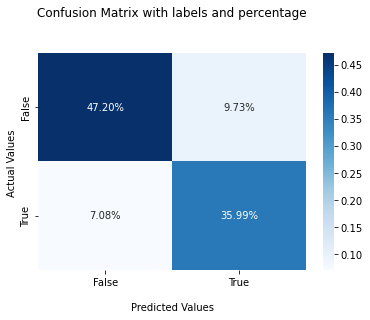

In [ ]:
import seaborn as sns
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix with labels and percentage\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

# Clickbait Detection

In [ ]:
x_train_clickbait=X_train.title
x_test_clickbait=X_test.title
y_train_clickbait=y_train.clickbait
y_test_clickbait=y_test.clickbait

# Preprossing

In [ ]:
def clickbait_tokenization(text):
    temp_lst=text.split()
    return temp_lst
x_train_clickbait=x_train_clickbait.apply(clickbait_tokenization)
x_test_clickbait=x_test_clickbait.apply(clickbait_tokenization)

In [ ]:
def clickbait_lowercasing(temp_lst):
    new_lst=[]
    for i in temp_lst:
        i=i.lower()
        new_lst.append(i)
    return new_lst
x_train_clickbait=x_train_clickbait.apply(clickbait_lowercasing)
x_test_clickbait=x_test_clickbait.apply(clickbait_lowercasing)  

In [ ]:
def clickbait_remove_punctuations(temp_lst):
    new_lst=[]
    for i in temp_lst:
        for j in s.punctuation:
            i=i.replace(j,'')
        new_lst.append(i)
    return new_lst
x_train_clickbait=x_train_clickbait.apply(clickbait_remove_punctuations)
x_test_clickbait=x_test_clickbait.apply(clickbait_remove_punctuations) 

In [ ]:
def clickbait_remove_numbers(temp_lst):
    nodig_lst=[]
    new_lst=[]
    for i in temp_lst:
        for j in s.digits:    
            i=i.replace(j,'')
        nodig_lst.append(i)
    for i in nodig_lst:
        if i!='':
            new_lst.append(i)
    return new_lst
x_train_clickbait=x_train_clickbait.apply(clickbait_remove_numbers)
x_test_clickbait=x_test_clickbait.apply(clickbait_remove_numbers)

In [ ]:
print("All stopwords of English language ")
", ".join(stopwords.words('english'))

All stopwords of English language 


"i, me, my, myself, we, our, ours, ourselves, you, you're, you've, you'll, you'd, your, yours, yourself, yourselves, he, him, his, himself, she, she's, her, hers, herself, it, it's, its, itself, they, them, their, theirs, themselves, what, which, who, whom, this, that, that'll, these, those, am, is, are, was, were, be, been, being, have, has, had, having, do, does, did, doing, a, an, the, and, but, if, or, because, as, until, while, of, at, by, for, with, about, against, between, into, through, during, before, after, above, below, to, from, up, down, in, out, on, off, over, under, again, further, then, once, here, there, when, where, why, how, all, any, both, each, few, more, most, other, some, such, no, nor, not, only, own, same, so, than, too, very, s, t, can, will, just, don, don't, should, should've, now, d, ll, m, o, re, ve, y, ain, aren, aren't, couldn, couldn't, didn, didn't, doesn, doesn't, hadn, hadn't, hasn, hasn't, haven, haven't, isn, isn't, ma, mightn, mightn't, mustn, mus

In [ ]:
def clickbait_remove_stopwords(temp_lst):
    stop=stopwords.words('english')
    new_lst=[]
    for i in temp_lst:
        if i not in stop:
            new_lst.append(i)
    return new_lst

x_train_clickbait=x_train_clickbait.apply(clickbait_remove_stopwords)
x_test_clickbait=x_test_clickbait.apply(clickbait_remove_stopwords)  

In [ ]:
def clickbait_remove_spaces(temp_lst):
    new_lst=[]
    for i in temp_lst:
        i=i.strip()
        new_lst.append(i)
    return new_lst
x_train_clickbait=x_train_clickbait.apply(clickbait_remove_spaces)
x_test_clickbait=x_test_clickbait.apply(clickbait_remove_spaces)

# Lemmetization

In [ ]:
lemmatizer=nltk.stem.WordNetLemmatizer()
def clickbait_lemmatzation(temp_lst):
    new_lst=[]
    for i in temp_lst:
        i=lemmatizer.lemmatize(i)
        new_lst.append(i)
    return new_lst
x_train_clickbait=x_train_clickbait.apply(clickbait_lemmatzation)
x_test_clickbait=x_test_clickbait.apply(clickbait_lemmatzation)

In [ ]:
x_train_clickbait=x_train_clickbait.apply(lambda x: ''.join(i+' ' for i in x))
x_test_clickbait=x_test_clickbait.apply(lambda x: ''.join(i+' ' for i in x))

In [ ]:
freq_dist={}
for i in x_train_clickbait:
    x=i.split()
    for j in x:
        if j not in freq_dist.keys():
            freq_dist[j]=1
        else:
            freq_dist[j]+=1
#freq_dist
max_v=0
for i in freq_dist.values():
  if(i > max_v):
    max_v = i

ct=0
for i in freq_dist.values():
  if(i > 2):
    ct+=1
ct

6105

# TF-IDF (Term frequency-Inverse Data Frequency)


In [ ]:
#analyzer="char_wb", ngram_range=(2,4)
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf=TfidfVectorizer(max_features=6105)
clickbait_train_1=tfidf.fit_transform(x_train_clickbait)
clickbait_test_1=tfidf.transform(x_test_clickbait)

In [ ]:
clickbait_train_arr=clickbait_train_1.toarray()
clickbait_test_arr=clickbait_test_1.toarray()

# Naive bayes Model

In [ ]:
NB_MN=MultinomialNB()

In [ ]:
NB_MN.fit(clickbait_train_arr,y_train_clickbait)
clickbait_pred=NB_MN.predict(clickbait_test_arr)
print('first 20 actual labels: ',y_test_clickbait.tolist()[:20])
print('first 20 predicted labels: ',clickbait_pred.tolist()[:20])

first 20 actual labels:  [0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]
first 20 predicted labels:  [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1]


In [ ]:
print("Accuracy of the model")
print(accuracy_score(y_test_clickbait,clickbait_pred))
print("Accuracy of the model in percentage")
print(accuracy_score(y_test_clickbait,clickbait_pred)*100,"%")

Accuracy of the model
0.8280010937927262
Accuracy of the model in percentage
82.80010937927263 %


In [ ]:
'''x_names = ["Clickbaits", "Non-Clickbaits"]
n_values = [nc,nnc]
fn_values = [fnc,fnnc] 
X_axis = np.arange(len(x_names))
  
plt.bar(X_axis - 0.15, n_values, 0.3, label = 'News')
for i in range(len(X_axis)):
        plt.text(i - 0.2,n_values[i],n_values[i])
plt.bar(X_axis + 0.15, fn_values, 0.3, label = 'Fake News')
for i in range(len(X_axis)):
        plt.text(i + 0.1,fn_values[i],fn_values[i])
plt.xticks(X_axis, x_names)
plt.xlabel("distribution of Fake News")
plt.ylabel("Number")

plt.legend()
plt.show()'''

'x_names = ["Clickbaits", "Non-Clickbaits"]\nn_values = [nc,nnc]\nfn_values = [fnc,fnnc] \nX_axis = np.arange(len(x_names))\n  \nplt.bar(X_axis - 0.15, n_values, 0.3, label = \'News\')\nfor i in range(len(X_axis)):\n        plt.text(i - 0.2,n_values[i],n_values[i])\nplt.bar(X_axis + 0.15, fn_values, 0.3, label = \'Fake News\')\nfor i in range(len(X_axis)):\n        plt.text(i + 0.1,fn_values[i],fn_values[i])\nplt.xticks(X_axis, x_names)\nplt.xlabel("distribution of Fake News")\nplt.ylabel("Number")\n\nplt.legend()\nplt.show()'

In [ ]:
'''checkdf = pd.DataFrame()
checkdf['actual_label']  = y_test_fakenews
checkdf['pred_label'] = Y_FakeNews_pred
checkdf['actual_clickbait'] = y_test_clickbait
checkdf['pred_clickbait'] = clickbait_pred
for i in range(len(checkdf)):
  checkdf['pred_label'] = checkdf['pred_label'].round(8)
checkdf'''

"checkdf = pd.DataFrame()\ncheckdf['actual_label']  = y_test_fakenews\ncheckdf['pred_label'] = Y_FakeNews_pred\ncheckdf['actual_clickbait'] = y_test_clickbait\ncheckdf['pred_clickbait'] = clickbait_pred\nfor i in range(len(checkdf)):\n  checkdf['pred_label'] = checkdf['pred_label'].round(8)\ncheckdf"

# Creating a hybrid model

In [ ]:
Fake_news_pred = Y_FakeNews_pred.tolist()
Fake_news_Binary_pred = NY_FakeNews_pred.tolist()
len(Fake_news_Binary_pred)

3657

In [ ]:
clickbait_news_pred = clickbait_pred.tolist()
len(clickbait_news_pred)

3657

In [ ]:
nc = 0
fnc = 0
fnnc = 0
nnc = 0
for i in range(len(Fake_news_Binary_pred)):
  if(Fake_news_Binary_pred[i] == 1):
    if(clickbait_news_pred[i] == 1):
      fnc+=1
    else:
      fnnc+=1
  else:
    if(clickbait_news_pred[i] == 1):
      nc+=1
    else:
      nnc+=1
print(nc,fnc,fnnc,nnc)
print("If clickbait then chance of fake news:", fnc*100/(fnc+nc))
print("If non-clickbait then chance of fake news:", fnnc*100/(fnnc+nnc))

221 211 1461 1764
If clickbait then chance of fake news: 48.842592592592595
If non-clickbait then chance of fake news: 45.30232558139535


In [ ]:
for i in range(len(Fake_news_Binary_pred)):
  if(clickbait_news_pred[i] == 1):
      #Fake_news_pred[i] = 0.60*Fake_news_pred[i] + 0.40*clickbait_news_pred[i]
      pass
  else:
      Fake_news_pred[i] = 0.55*Fake_news_pred[i] + 0.45*clickbait_news_pred[i]
      
Final_binary = []      
for i in range(len(Fake_news_pred)):
  if(Fake_news_pred[i]>=0.5):
    Final_binary.append(1)
  else:
    Final_binary.append(0)

In [ ]:
nc = 0
fnc = 0
fnnc = 0
nnc = 0
for i in range(len(Final_binary)):
  if(Final_binary[i] == 1):
    if(clickbait_news_pred[i] == 1):
      fnc+=1
    else:
      fnnc+=1
  else:
    if(clickbait_news_pred[i] == 1):
      nc+=1
    else:
      nnc+=1
print(nc,fnc,fnnc,nnc)
print("If clickbait then chance of fake news:", fnc*100/(fnc+nc))
print("If non-clickbait then chance of fake news:", fnnc*100/(fnnc+nnc))

210 222 1419 1806
If clickbait then chance of fake news: 51.388888888888886
If non-clickbait then chance of fake news: 44.0


In [ ]:
final = pd.Series(Fake_news_pred)
type(final)

pandas.core.series.Series

In [ ]:
Nfinal = np.where(final > 0.5, 1, 0)
cf_matrix=confusion_matrix(y_final_test, Nfinal)
print(accuracy_score(y_final_test, Nfinal))
print(cf_matrix)

0.8326497128794094
[[1743  339]
 [ 273 1302]]


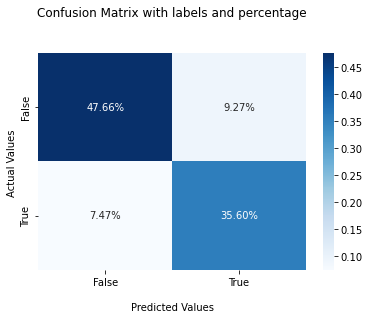

In [ ]:
import seaborn as sns
ax = sns.heatmap(cf_matrix/np.sum(cf_matrix), annot=True,fmt='.2%', cmap='Blues')
ax.set_title('Confusion Matrix with labels and percentage\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');
ax.xaxis.set_ticklabels(['False','True'])
ax.yaxis.set_ticklabels(['False','True'])
plt.show()

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(y_final_test, Nfinal))

              precision    recall  f1-score   support

           0       0.86      0.84      0.85      2082
           1       0.79      0.83      0.81      1575

    accuracy                           0.83      3657
   macro avg       0.83      0.83      0.83      3657
weighted avg       0.83      0.83      0.83      3657

